## Finding Your Way In The City

In this notebook you'll combine the work of previous exercises to calculate a minimal series of waypoints in order to get from a start location to a goal location.

You'll reuse and modify your algorithms from:

- A*
- Configuration Space
- Collinearity and/or Bresenham

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

from grid import create_grid
from astar import a_star_grid, heuristic

%matplotlib inline

#from bresenham import bresenham

In [2]:
plt.rcParams['figure.figsize'] = 12, 12

You'll notice we've imported `create_grid`, and `a_star`. These are functions you've implemented in previous exercises, and here you'll use them to create a map and find a path from a starting position to a goal position.

To read the function signature and documentation execute `?` followed by the function name in a cell. In the example below we'll check the documentation for `create_grid`.

In [3]:
?create_grid

If you would like to alter these implementations, you can modify [grid.py](/edit/grid.py) and [planning.py](/edit/planning.py) in the current directory.

In [5]:
# This is the same obstacle data from the previous lesson.
filename = '../colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


In [9]:
# Static drone altitude (meters)
drone_altitude = 5
safe_distance = 3
grid,_,_ = create_grid(data, drone_altitude, safe_distance)

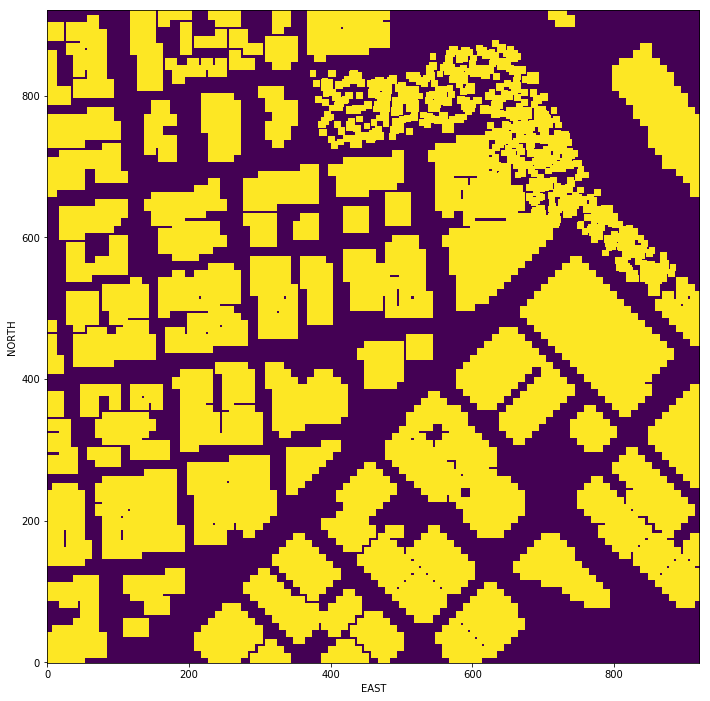

In [10]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower') 

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Next you'll compute the path from a start location to a goal location using A*.

Start and goal coordinates in *(north, east)*.

In [11]:
start_ne = (25,  100)
goal_ne = (750., 370.)

Compute the lowest cost path with `a_star`. 

In [14]:
# TODO: use `a_star` to compute the lowest cost path
path, cost = a_star_grid(grid, heuristic, start_ne, goal_ne)
print(path, cost)

Found a path.
[((25, 100), <Action.SE: (1, 1, 1.4142135623730951)>), ((26, 101), <Action.SE: (1, 1, 1.4142135623730951)>), ((27, 102), <Action.SE: (1, 1, 1.4142135623730951)>), ((28, 103), <Action.SE: (1, 1, 1.4142135623730951)>), ((29, 104), <Action.SE: (1, 1, 1.4142135623730951)>), ((30, 105), <Action.SE: (1, 1, 1.4142135623730951)>), ((31, 106), <Action.SE: (1, 1, 1.4142135623730951)>), ((32, 107), <Action.SE: (1, 1, 1.4142135623730951)>), ((33, 108), <Action.SE: (1, 1, 1.4142135623730951)>), ((34, 109), <Action.SE: (1, 1, 1.4142135623730951)>), ((35, 110), <Action.SE: (1, 1, 1.4142135623730951)>), ((36, 111), <Action.RIGHT: (0, 1, 1)>), ((36, 112), <Action.RIGHT: (0, 1, 1)>), ((36, 113), <Action.RIGHT: (0, 1, 1)>), ((36, 114), <Action.RIGHT: (0, 1, 1)>), ((36, 115), <Action.RIGHT: (0, 1, 1)>), ((36, 116), <Action.RIGHT: (0, 1, 1)>), ((36, 117), <Action.RIGHT: (0, 1, 1)>), ((36, 118), <Action.RIGHT: (0, 1, 1)>), ((36, 119), <Action.RIGHT: (0, 1, 1)>), ((36, 120), <Action.RIGHT: (0, 

Let's plot the path!

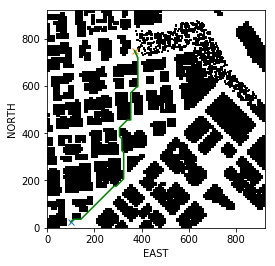

In [16]:
plt.imshow(grid, cmap='Greys', origin='lower')

# For the purposes of the visual the east coordinate lay along
# the x-axis and the north coordinates long the y-axis.
plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if path is not None:
    pp = np.array([p[0] for p in path])
    plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

Pretty neat! Unfortunately this path is impractical, the drone would be constantly stopping and going since each grid cell visited is synonymous with a waypoint. Ideally, we'd like to only consider a new waypoint when the drone's direction changes. Path pruning is one way to achieve this result.

### Path Pruning

In [17]:
def point(p):
    return np.array([p[0], p[1], 1.]).reshape(1, -1)

def collinearity_check(p1, p2, p3, epsilon=1e-6):   
    m = np.concatenate((p1, p2, p3), 0)
    det = np.linalg.det(m)
    return abs(det) < epsilon

Complete the `prune_path` function below. It should return a new path much shorter than the original.

In [18]:
def prune_path(path):
    if path is not None:
        pruned_path = [path[0]]
        next_ind = 0
        for next_ind in range(1, len(path)-1):
            if not collinearity_check(point(pruned_path[-1]), 
                                      point(path[next_ind]), 
                                      point(path[next_ind+1])):
                pruned_path.append(path[next_ind])
        pruned_path.append(path[-1])
        
    else:
        pruned_path = path
        
    return pruned_path

Prune the path.

In [19]:
pruned_path = prune_path([p[0] for p in path])
print(pruned_path)

[(25, 100), (36, 111), (36, 143), (176, 283), (176, 293), (207, 324), (319, 324), (327, 316), (377, 316), (387, 306), (423, 306), (456, 339), (456, 353), (457, 354), (571, 354), (596, 379), (596, 383), (597, 384), (720, 384), (721, 383), (722, 383), (723, 382), (724, 382), (725, 381), (726, 381), (727, 380), (729, 380), (730, 379), (731, 379), (732, 378), (733, 378), (734, 377), (735, 377), (736, 376), (737, 376), (738, 375), (740, 375), (741, 374), (742, 374), (743, 373), (744, 373), (745, 372), (746, 372), (747, 371), (748, 371), (749, 370), (750.0, 370.0)]


In [20]:
pruned_path

[(25, 100),
 (36, 111),
 (36, 143),
 (176, 283),
 (176, 293),
 (207, 324),
 (319, 324),
 (327, 316),
 (377, 316),
 (387, 306),
 (423, 306),
 (456, 339),
 (456, 353),
 (457, 354),
 (571, 354),
 (596, 379),
 (596, 383),
 (597, 384),
 (720, 384),
 (721, 383),
 (722, 383),
 (723, 382),
 (724, 382),
 (725, 381),
 (726, 381),
 (727, 380),
 (729, 380),
 (730, 379),
 (731, 379),
 (732, 378),
 (733, 378),
 (734, 377),
 (735, 377),
 (736, 376),
 (737, 376),
 (738, 375),
 (740, 375),
 (741, 374),
 (742, 374),
 (743, 373),
 (744, 373),
 (745, 372),
 (746, 372),
 (747, 371),
 (748, 371),
 (749, 370),
 (750.0, 370.0)]

Replot the path, it will be the same as before but the drone flight will be much smoother.

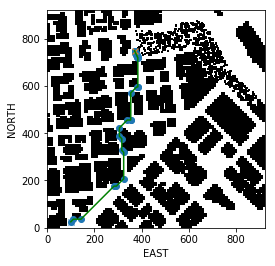

In [21]:
plt.imshow(grid, cmap='Greys', origin='lower')

plt.plot(start_ne[1], start_ne[0], 'x')
plt.plot(goal_ne[1], goal_ne[0], 'x')

if pruned_path is not None:
    pp = np.array(pruned_path)
    plt.plot(pp[:, 1], pp[:, 0], 'g')
    plt.scatter(pp[:, 1], pp[:, 0])

plt.xlabel('EAST')
plt.ylabel('NORTH')

plt.show()

Now the waypoints symbolize a change in direction, much better!

[solution](/notebooks/A-Star-City-Solution.ipynb)